# PyTorch 기초: 가설, 손실함수, 최적화

## 1. 필요한 라이브러리

In [41]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# 재현성을 위한 시드 설정
torch.manual_seed(42)

## 2. 가설(Hypothesis)

### 2.1 가설이란?
가설은 입력 데이터로부터 출력을 예측하는 함수입니다.

선형 회귀의 경우: $H(x) = Wx + b$

- W: 가중치(weight)
- b: 편향(bias)
- x: 입력값

### 2.2 PyTorch로 가설 구현하기

In [42]:
# 선형 회귀 모델 정의
class LinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        # 입력 1개, 출력 1개인 선형 레이어
        self.linear = nn.Linear(1, 1)

    def forward(self, x):
        return self.linear(x)

# 모델 인스턴스 생성
model = LinearRegression()

# 모델 구조 출력
print("모델 구조:")
print(model)
print("\n가중치:", model.linear.weight.item())
print("편향:", model.linear.bias.item())

모델 구조:
LinearRegression(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)

가중치: 0.7645385265350342
편향: 0.8300079107284546


1. `nn.Module`을 상속받아 모델 클래스를 정의합니다.
2. `__init__` 메서드에서 `nn.Linear(1, 1)`로 단순 선형 레이어를 생성합니다.
3. `forward` 메서드는 입력을 받아 선형 변환을 수행합니다.
4. 위에 보이는 가중치 & 편향은 선형 회귀 모델의 초기값입니다.
    - PyTorch는 모델을 생성할 때 자동으로 가중치와 편향을 랜덤하게 초기화합니다.
    - 학습 전의 시작점이라고 볼 수 있습니다.

**예시 데이터로 가설 테스트:**

torch.Size([100, 1])
tensor([[-5.0000],
        [-4.8990],
        [-4.7980],
        [-4.6970],
        [-4.5960],
        [-4.4949],
        [-4.3939],
        [-4.2929],
        [-4.1919],
        [-4.0909],
        [-3.9899],
        [-3.8889],
        [-3.7879],
        [-3.6869],
        [-3.5859],
        [-3.4848],
        [-3.3838],
        [-3.2828],
        [-3.1818],
        [-3.0808],
        [-2.9798],
        [-2.8788],
        [-2.7778],
        [-2.6768],
        [-2.5758],
        [-2.4747],
        [-2.3737],
        [-2.2727],
        [-2.1717],
        [-2.0707],
        [-1.9697],
        [-1.8687],
        [-1.7677],
        [-1.6667],
        [-1.5657],
        [-1.4646],
        [-1.3636],
        [-1.2626],
        [-1.1616],
        [-1.0606],
        [-0.9596],
        [-0.8586],
        [-0.7576],
        [-0.6566],
        [-0.5556],
        [-0.4545],
        [-0.3535],
        [-0.2525],
        [-0.1515],
        [-0.0505],
        [ 0.0505],
        [ 

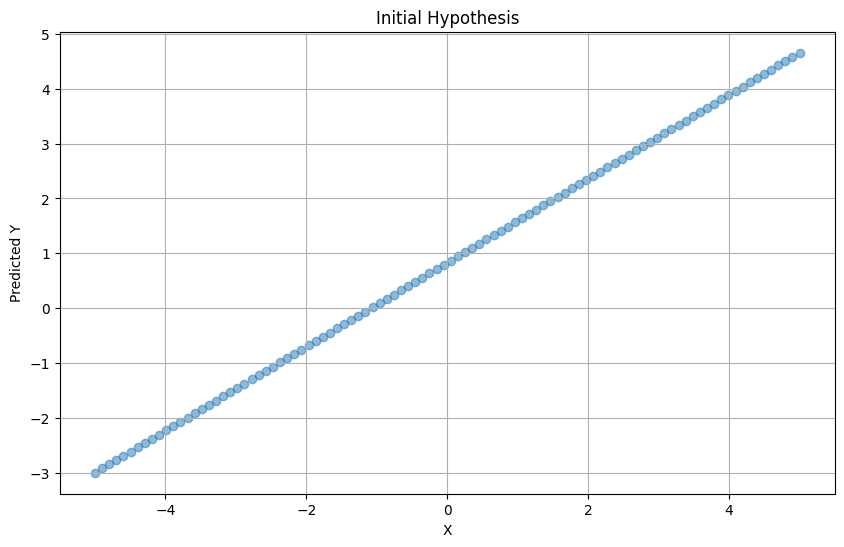

In [43]:
# 테스트 데이터 생성
X = torch.linspace(-5, 5, 100).reshape(-1, 1)
print(X.shape)
print(X)
y_pred = model(X)  # 초기 가중치와 편향으로 예측

# 시각화
plt.figure(figsize=(10, 6))
plt.scatter(X.numpy(), y_pred.detach().numpy(), alpha=0.5)
plt.title('Initial Hypothesis')
plt.xlabel('X')
plt.ylabel('Predicted Y')
plt.grid(True)
plt.show()

이는 초기 모델의 예측을 보여주는 것입니다.

-> 가중치: 0.764538526535034 & 편향: 0.8300079107284546 이미로, y = 0.7645x + 0.8300 형태의 직선으로 예측을 한 것이라고 볼 수 있습니다.

## 3. 손실함수(Loss Function)

### 3.1 손실함수란?

손실함수는 모델의 예측이 실제 값과 얼마나 차이나는지 측정합니다.

MSE(Mean Squared Error)는 가장 기본적인 손실함수입니다:

$MSE = \frac{1}{n}\sum_{i=1}^n(y_i - H(x_i))^2$

### 3.2 PyTorch로 손실함수 구현하기

초기 손실값: 13.5423


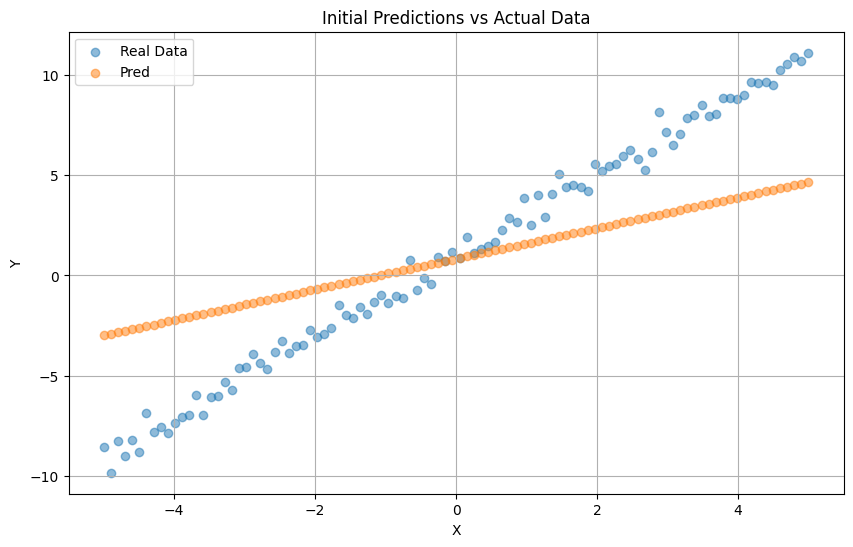

In [44]:
# 실제 데이터 생성 (y = 2x + 1 + noise)
X_train = torch.linspace(-5, 5, 100).reshape(-1, 1)
y_train = 2 * X_train + 1 + torch.randn_like(X_train) * 0.5  # 실제 데이터

# MSE 손실함수 정의
criterion = nn.MSELoss()

# 현재 모델의 예측
y_pred = model(X_train)

# 손실 계산
loss = criterion(y_pred, y_train)

print(f"초기 손실값: {loss.item():.4f}")

# 시각화
plt.figure(figsize=(10, 6))
plt.scatter(X_train.numpy(), y_train.numpy(), alpha=0.5, label='Real Data')
plt.scatter(X_train.numpy(), y_pred.detach().numpy(), alpha=0.5, label='Pred')
plt.title('Initial Predictions vs Actual Data')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()

1. 실제 데이터는 y = 2x + 1 공식에 약간의 노이즈를 추가하여 생성
2. `nn.MSELoss()`로 MSE 손실함수 생성
3. 모델의 예측과 실제 값으로 손실 계산
4. 결과 시각화로 현재 예측이 얼마나 부정확한지 확인

## 4. 최적화(Optimization)

### 4.1 최적화란?
최적화는 손실을 최소화하도록 모델의 파라미터(가중치와 편향)를 조정하는 과정입니다.

SGD(Stochastic Gradient Descent)는 기본적인 최적화 알고리즘입니다.

### 4.2 PyTorch로 최적화 구현하기

#### 1. `torch.optim.SGD`로 옵티마이저 생성 (학습률 0.01)

In [45]:
# 옵티마이저 정의
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# 학습 과정
losses = []  # 손실값 기록용
epochs = 100  # 학습 반복 횟수

for epoch in range(epochs):
    # 예측
    y_pred = model(X_train)

    # 손실 계산
    loss = criterion(y_pred, y_train)
    losses.append(loss.item())

    # 역전파 및 최적화
    optimizer.zero_grad()  # 기존 그래디언트 초기화
    loss.backward()       # 역전파로 그래디언트 계산
    optimizer.step()      # 파라미터 업데이트

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# 최종 손실값 출력
print(f'최종 손실값: {loss.item():.4f}')

Epoch [10/100], Loss: 0.7036
Epoch [20/100], Loss: 0.2442
Epoch [30/100], Loss: 0.2290
Epoch [40/100], Loss: 0.2259
Epoch [50/100], Loss: 0.2240
Epoch [60/100], Loss: 0.2227
Epoch [70/100], Loss: 0.2219
Epoch [80/100], Loss: 0.2213
Epoch [90/100], Loss: 0.2209
Epoch [100/100], Loss: 0.2207
최종 손실값: 0.2207


각 에폭마다:
   - 예측 수행
   - 손실 계산
   - `optimizer.zero_grad()`로 이전 그래디언트 초기화
   - `loss.backward()`로 역전파 수행
   - `optimizer.step()`으로 파라미터 업데이트

-> Loss가 0.7036에서 0.2207로 지속적으로 감소

#### 2. 학습 과정과 최종 결과 시각화

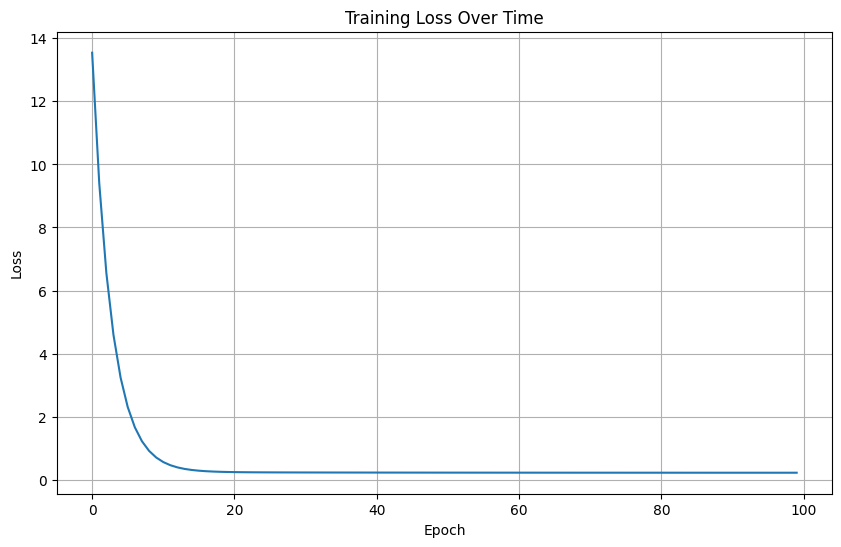

In [46]:
# 학습 과정 시각화
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.title('Training Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

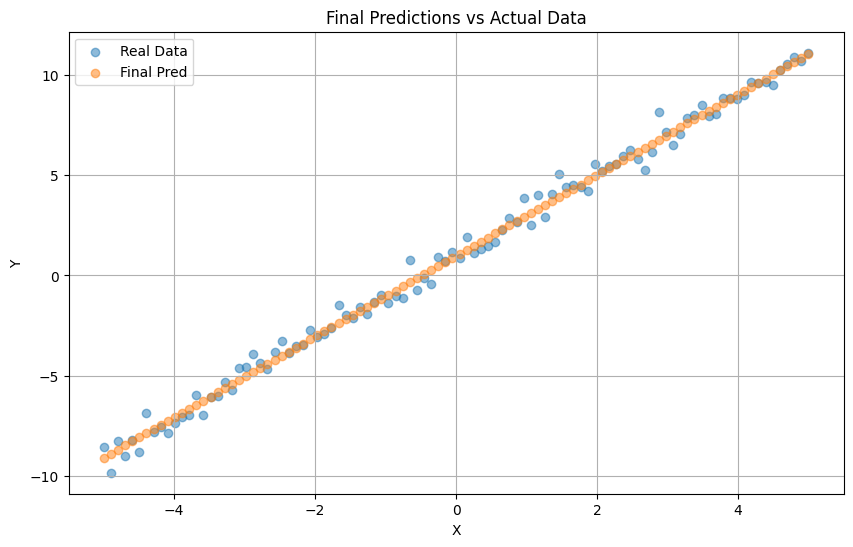


최종 모델 파라미터:
가중치: 2.0150
편향: 0.9743


In [47]:
# 최종 결과 시각화
plt.figure(figsize=(10, 6))
plt.scatter(X_train.numpy(), y_train.numpy(), alpha=0.5, label='Real Data')
plt.scatter(X_train.numpy(), model(X_train).detach().numpy(),
           alpha=0.5, label='Final Pred')
plt.title('Final Predictions vs Actual Data')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()

print("\n최종 모델 파라미터:")
print(f"가중치: {model.linear.weight.item():.4f}")
print(f"편향: {model.linear.bias.item():.4f}")

1. 최종 가중치(2.0150)가 실제 데이터 생성식의 계수(2)와 매우 유사
2. 최종 편향(0.9743)이 실제 데이터 생성식의 편향(1)과 매우 유사
3. Loss가 0에 가깝지 않은 것은 데이터에 노이즈가 있기 때문에 정상

```
# 학습 전
y = 0.7645x + 0.8300  # 초기 모델

# 목표
y = 2x + 1 + noise    # 실제 데이터

# 학습 후
y = 2.0150x + 0.9743  # 최종 모델
```

## 5. 전체 학습 과정 해석

### 5.1 학습 결과 분석
- 손실이 시간에 따라 감소하는 것은 모델이 학습하고 있다는 증거
- 최종 가중치가 2에 가깝고 편향이 1에 가까우면 원래 데이터 생성 공식(y = 2x + 1)을 잘 학습했다는 의미
- 완벽하게 일치하지 않는 것은 데이터에 노이즈가 있기 때문

### 5.2 실습 과제
1. 학습률을 변경해보면서 학습 속도와 안정성 비교
2. 에폭 수를 조절하면서 과적합/과소적합 관찰
3. 다른 옵티마이저(Adam 등)를 사용해보고 성능 비교

- 어떻게 적용해야할 지 모르는 케이스에 대해서는 ChatGPT를 활용하지만, 학습 결과에 대한 리포팅을 해주세요!
- 리포팅한 것은 노션 페이지에 공유해주시면 됩니다!

### 1. 학습률을 변경해보면서 학습 속도와 안정성 비교

학습률: 0.1, 최종 손실값: 0.2407
학습률: 0.01, 최종 손실값: 0.2893
학습률: 0.001, 최종 손실값: 2.6964
학습률: 0.0001, 최종 손실값: 28.9595
학습률: 1e-05, 최종 손실값: 62.0259


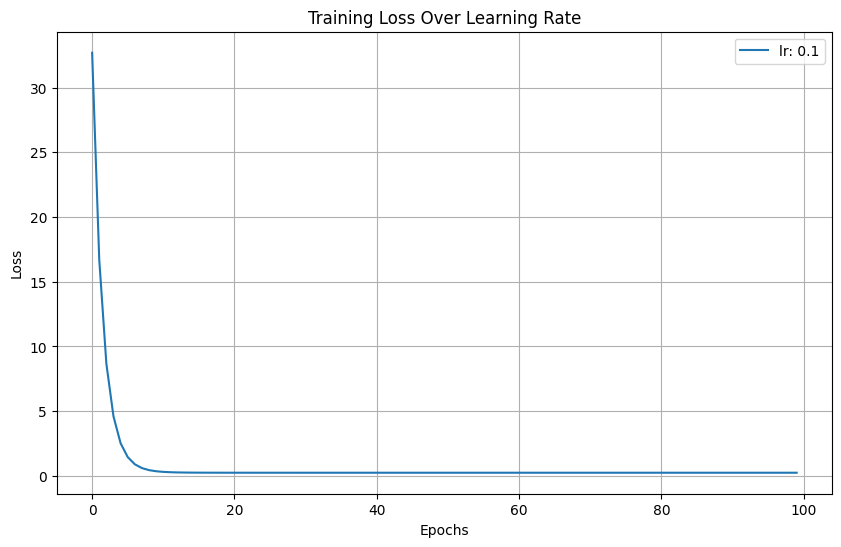

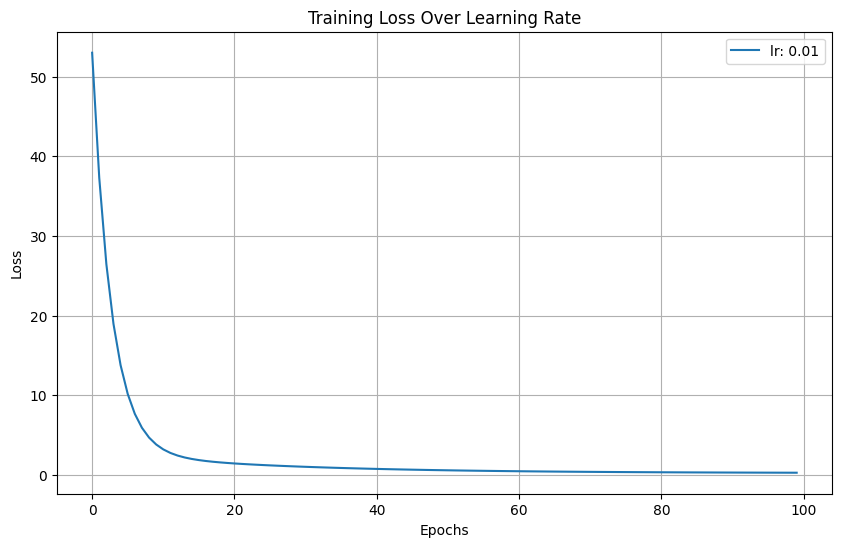

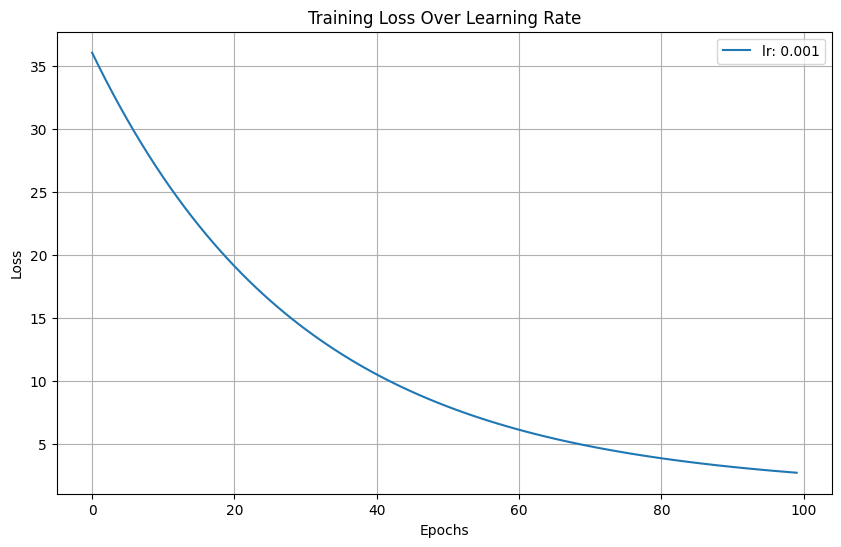

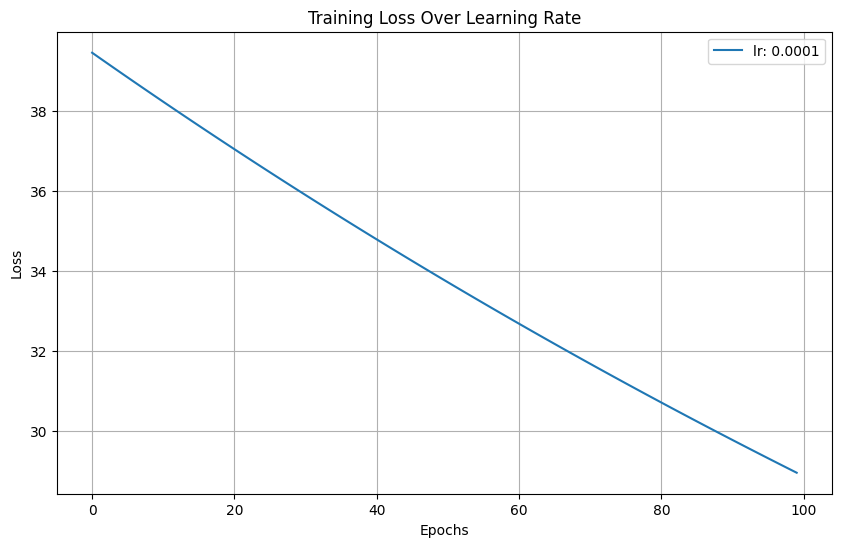

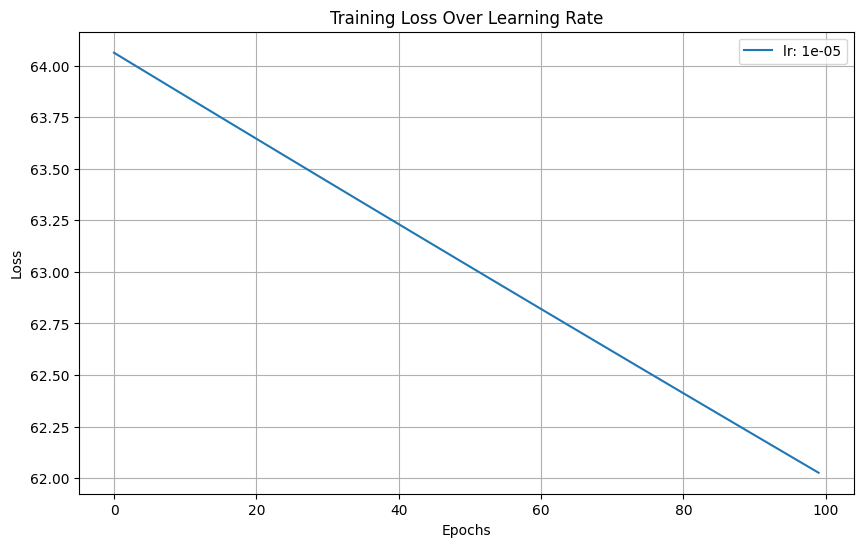

In [83]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# 재현성을 위한 시드 설정
torch.manual_seed(42)

# 선형 회귀 모델 정의
class LinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        # 입력 1개, 출력 1개인 선형 레이어
        self.linear = nn.Linear(1, 1)

    def forward(self, x):
        return self.linear(x)


# 실제 데이터 생성 (y = 2x + 1 + noise)
X_train = torch.linspace(-5, 5, 100).reshape(-1, 1)
y_train = 2 * X_train + 1 + torch.randn_like(X_train) * 0.5  # 실제 데이터


lr_list = [0.1, 0.01, 0.001, 0.0001, 0.00001]

# MSE 손실함수 정의
criterion = nn.MSELoss()

# 손실 계산
loss = criterion(y_pred, y_train)

for lr in lr_list:

  # 모델 인스턴스 생성
  model = LinearRegression()

  # 옵티마이저 정의
  optimizer = torch.optim.SGD(model.parameters(), lr=lr)

  # 학습 과정
  losses = []  # 손실값 기록용
  epochs = 100  # 학습 반복 횟수

  for epoch in range(epochs):
      # 예측
      y_pred = model(X_train)

      # 손실 계산
      loss = criterion(y_pred, y_train)
      losses.append(loss.item())

      # 역전파 및 최적화
      optimizer.zero_grad()  # 기존 그래디언트 초기화
      loss.backward()       # 역전파로 그래디언트 계산
      optimizer.step()      # 파라미터 업데이트

      # if (epoch + 1) % 10 == 0:
      #     print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

  # 최종 손실값 출력
  print(f'학습률: {lr}, 최종 손실값: {loss.item():.4f}')
  plt.figure(figsize=(10, 6))
  plt.plot(losses, label=f'lr: {lr}')
  plt.title(f"Training Loss Over Learning Rate")
  plt.legend()
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.grid(True)
plt.show()

### 2. 에폭 수를 조절하면서 과적합/과소적합 관찰

Epoch: 10, 최종 손실값: 3.7820
학습률: 1e-05, 최종 손실값: 3.7820
Epoch: 100, 최종 손실값: 0.2893
학습률: 1e-05, 최종 손실값: 0.2893
Epoch: 1000, 최종 손실값: 0.2407
학습률: 1e-05, 최종 손실값: 0.2407
Epoch: 10000, 최종 손실값: 0.2407
학습률: 1e-05, 최종 손실값: 0.2407


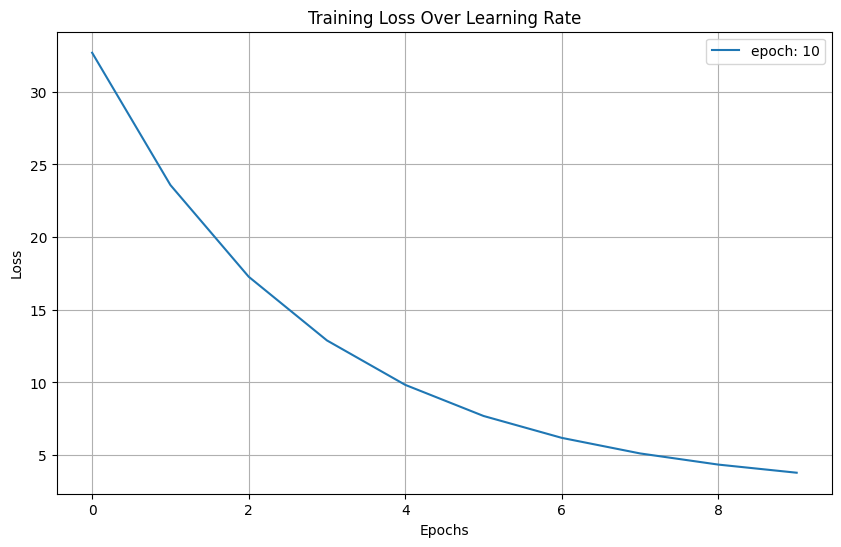

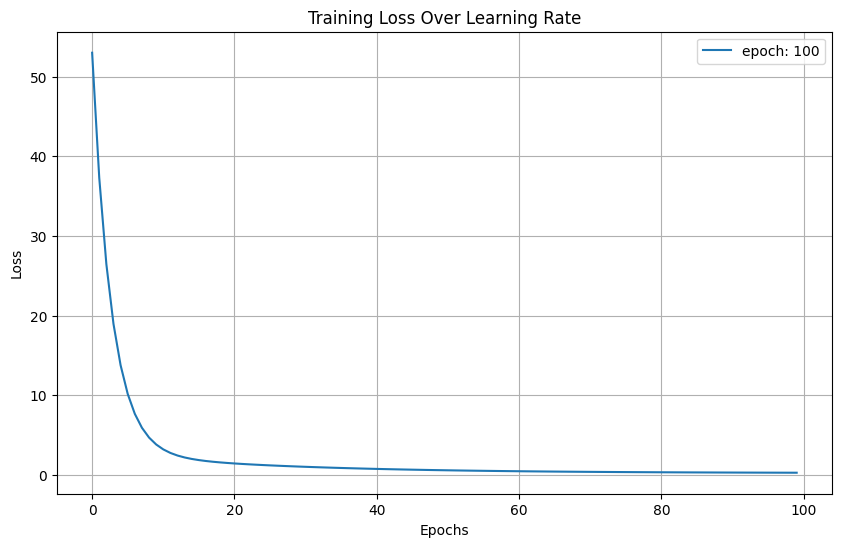

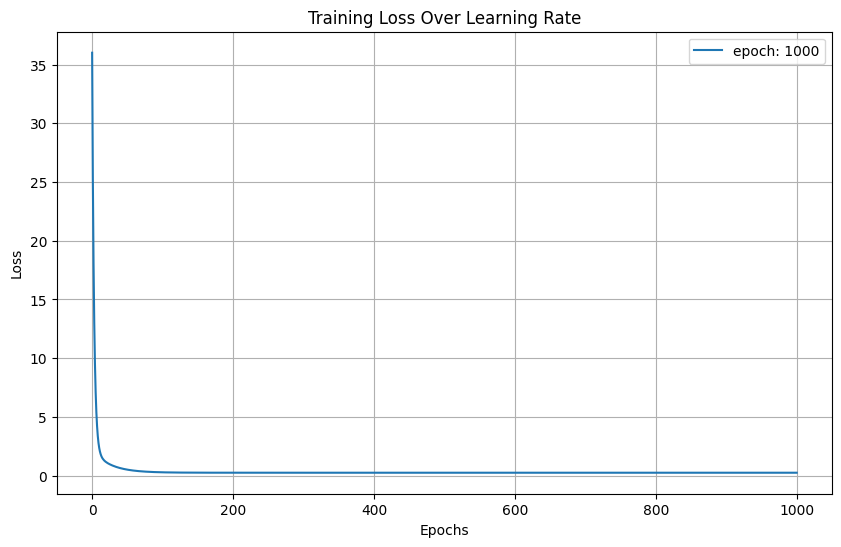

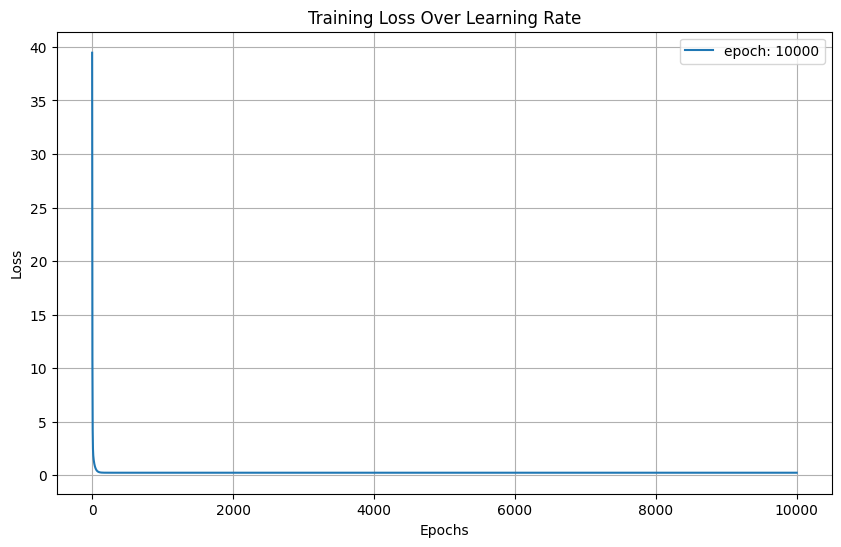

In [86]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# 재현성을 위한 시드 설정
torch.manual_seed(42)

# 선형 회귀 모델 정의
class LinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        # 입력 1개, 출력 1개인 선형 레이어
        self.linear = nn.Linear(1, 1)

    def forward(self, x):
        return self.linear(x)


# 실제 데이터 생성 (y = 2x + 1 + noise)
X_train = torch.linspace(-5, 5, 100).reshape(-1, 1)
y_train = 2 * X_train + 1 + torch.randn_like(X_train) * 0.5  # 실제 데이터


epochs_list = [10, 100, 1000, 10000]

# MSE 손실함수 정의
criterion = nn.MSELoss()

# 손실 계산
loss = criterion(y_pred, y_train)

for epochs in epochs_list:

  # 모델 인스턴스 생성
  model = LinearRegression()

  # 옵티마이저 정의
  optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

  # 학습 과정
  losses = []  # 손실값 기록용

  for epoch in range(epochs):
      # 예측
      y_pred = model(X_train)

      # 손실 계산
      loss = criterion(y_pred, y_train)
      losses.append(loss.item())

      # 역전파 및 최적화
      optimizer.zero_grad()  # 기존 그래디언트 초기화
      loss.backward()       # 역전파로 그래디언트 계산
      optimizer.step()      # 파라미터 업데이트

      # if (epoch + 1) % 10 == 0:
      #     print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

  # 최종 손실값 출력
  print(f'Epoch: {epochs}, 최종 손실값: {loss.item():.4f}')
  print(f'학습률: {lr}, 최종 손실값: {loss.item():.4f}')
  plt.figure(figsize=(10, 6))
  plt.plot(losses, label=f'epoch: {epoch+1}')
  plt.title(f"Training Loss Over Learning Rate")
  plt.legend()
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.grid(True)
plt.show()

### 3. 다른 옵티마이저(Adam 등)를 사용해보고 성능 비교

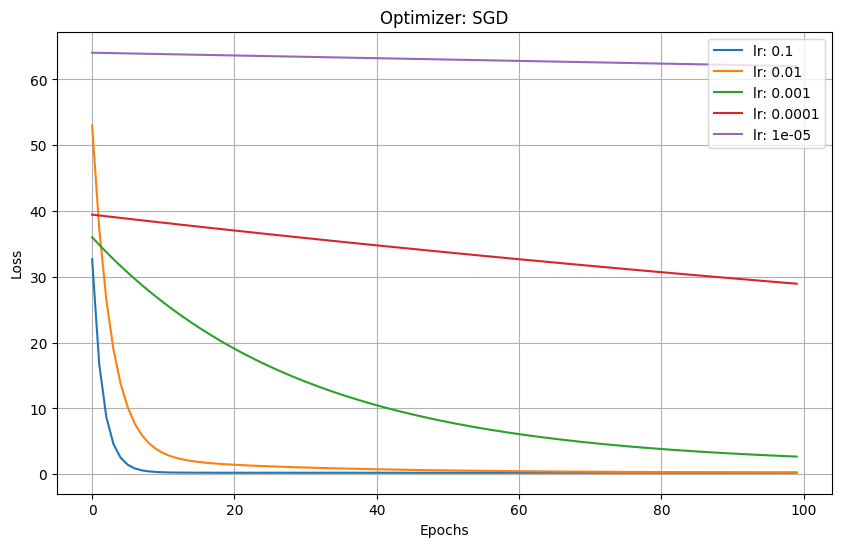

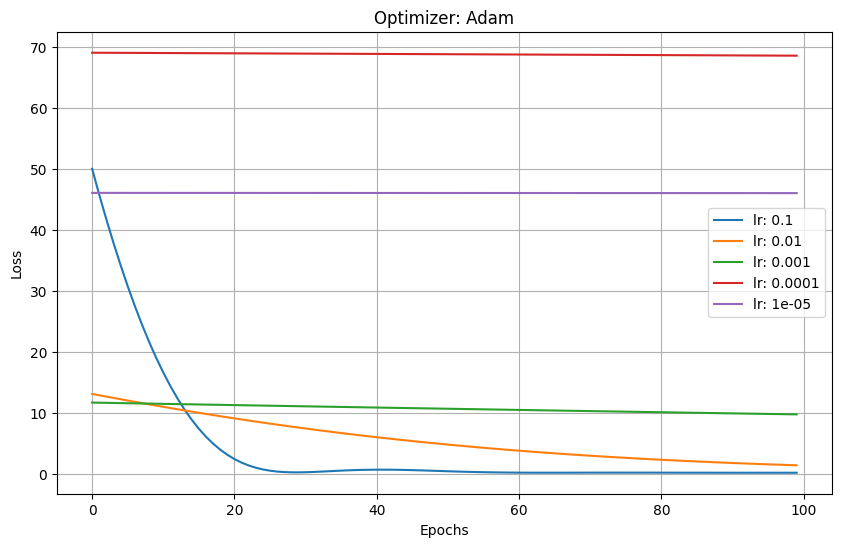

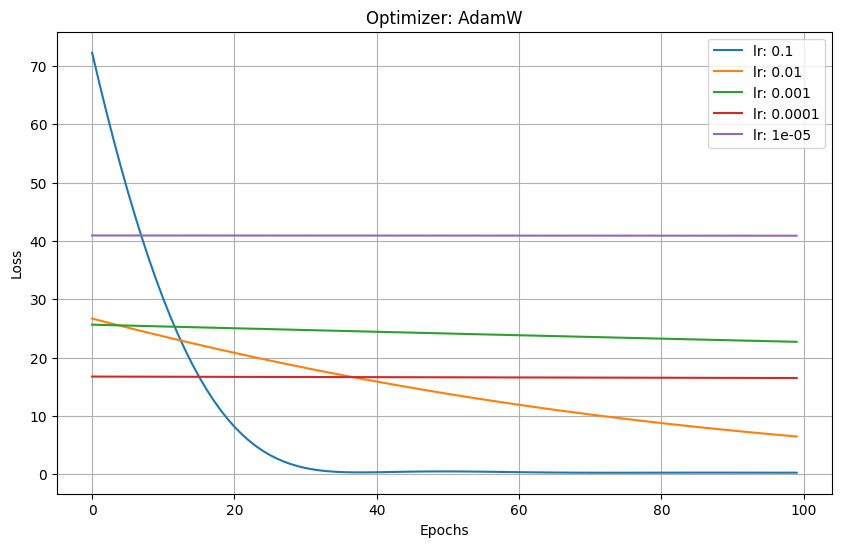

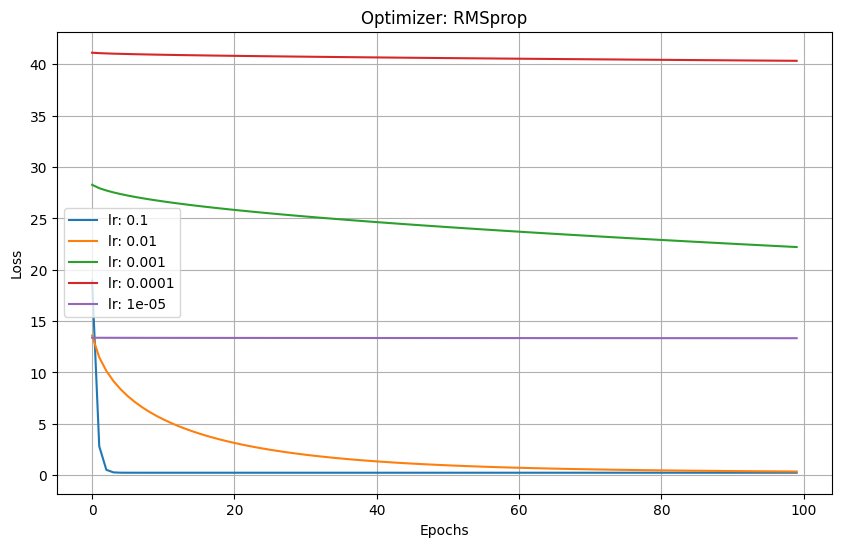

In [79]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# 재현성을 위한 시드 설정
torch.manual_seed(42)

# 선형 회귀 모델 정의
class LinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        # 입력 1개, 출력 1개인 선형 레이어
        self.linear = nn.Linear(1, 1)

    def forward(self, x):
        return self.linear(x)


# 실제 데이터 생성 (y = 2x + 1 + noise)
X_train = torch.linspace(-5, 5, 100).reshape(-1, 1)
y_train = 2 * X_train + 1 + torch.randn_like(X_train) * 0.5  # 실제 데이터

optimizer_list = [torch.optim.SGD, torch.optim.Adam,torch.optim.AdamW, torch.optim.RMSprop]
optimizer_loss_map ={
    torch.optim.SGD.__name__:[],
    torch.optim.Adam.__name__:[],
    torch.optim.AdamW.__name__:[],
    torch.optim.RMSprop.__name__:[]
    }
lr_list = [0.1, 0.01, 0.001, 0.0001, 0.00001]

# MSE 손실함수 정의
criterion = nn.MSELoss()

# 손실 계산
loss = criterion(y_pred, y_train)
for op in optimizer_list:
  for lr in lr_list:

    # 모델 인스턴스 생성
    model = LinearRegression()

    # 옵티마이저 정의
    # optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    optimizer = op(model.parameters(), lr=lr)
    # 학습 과정
    losses = []  # 손실값 기록용
    epochs = 100  # 학습 반복 횟수

    for epoch in range(epochs):
        # 예측
        y_pred = model(X_train)

        # 손실 계산
        loss = criterion(y_pred, y_train)
        losses.append(loss.item())

        # 역전파 및 최적화
        optimizer.zero_grad()  # 기존 그래디언트 초기화
        loss.backward()       # 역전파로 그래디언트 계산
        optimizer.step()      # 파라미터 업데이트
    optimizer_loss_map[op.__name__].append(losses)

    # 최종 손실값 출력
    # print(f'Optimizer: {op}, Learning Rate: {lr}, 최종 손실값: {loss.item():.4f}')

  plt.figure(figsize=(10, 6))
  for loss, lr in zip(optimizer_loss_map[op.__name__], lr_list):
    plt.plot(loss, label=f'lr: {lr}')
  plt.title(f"Optimizer: {op.__name__}")
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)
  plt.show()



**주의사항:**
- 학습률이 너무 크면 학습이 불안정할 수 있음
- 반대로 너무 작으면 학습이 매우 느림
- 실제 응용에서는 데이터를 훈련/검증 세트로 나누어야 함

## 참고자료
- [PyTorch 공식 튜토리얼](https://pytorch.org/tutorials/)
- [Deep Learning Book](https://www.deeplearningbook.org/)